In [1]:
from online.Environment import BatteryScheduling
from online.EnergyDataset import EnergyDataset
from torchrl.envs.utils import check_env_specs
from hydra import initialize, compose
from torchrl.modules import MLP, Actor,OrnsteinUhlenbeckProcessModule, TanhModule
import torch
from torchrl.envs import (
    CatTensors,
    TransformedEnv,
    UnsqueezeTransform,
    Compose,
    InitTracker,
)

from tensordict.nn import TensorDictModule, TensorDictSequential

from torchrl.objectives import ValueEstimators, SoftUpdate, DDPGLoss
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, ReplayBuffer, RandomSampler

In [2]:
ds_train = EnergyDataset('../data/1_processed/energy.csv', '../data/1_processed/price.csv', 48, 1, 'train')
ds_test = EnergyDataset('../data/1_processed/energy.csv', '../data/1_processed/price.csv', 48, 1, 'test')

In [3]:
def makeEnv(cfg, seed, ds):
    env = BatteryScheduling(cfg, 42, ds)
    env_transformed = TransformedEnv(env, 
                                     Compose(InitTracker(),
                                             UnsqueezeTransform(dim=-1, 
                                                                in_keys=['soe', 'prosumption', 'price', 'cost'],
                                                                in_keys_inv=['soe', 'prosumption', 'price', 'cost'],),
                                            CatTensors(dim=-1,
                                                        in_keys=['time_feature', 'soe', 'prosumption','price'],
                                                        out_key='observation',
                                                        del_keys=False),
                                     )
                                    )
    return env_transformed

In [4]:
with initialize(version_base=None, config_path="conf/"):
    cfg = compose(config_name='config.yaml')
    env_train = makeEnv(cfg, 42, ds_train)
  
    # check_env_specs(env_train)


    policy_net = MLP(
        in_features=env_train.observation_spec['observation'].shape[-1],
        out_features=env_train.action_spec.shape.numel(),
        depth=2,
        num_cells=[400,300],
        activation_class=torch.nn.ReLU,
    )

    policy_module = TensorDictModule(
        module=policy_net,
        in_keys=['observation'],
        out_keys=['action']
    )

    actor = TensorDictSequential(
        policy_module,
        TanhModule(
            spec=env_train.full_action_spec['action'],
            in_keys=['action'],
            out_keys=['action'],
        ),
    )

    # actor = Actor(
    #     module=policy_module,
    #     spec=env_train.full_action_spec['action'],
    #     in_keys=['observation'],
    #     out_keys=['action'],
    # )


    ou = OrnsteinUhlenbeckProcessModule(
        # annealing_num_steps=5_000,
        # n_steps_annealing=5_000,
        spec=actor[-1].spec.clone(),
    )

    exploration_policy = TensorDictSequential(
        actor,
        ou
    )


    critic_module = TensorDictModule(
        module=MLP(
            in_features=env_train.observation_spec['observation'].shape[-1] + env_train.full_action_spec['action'].shape.numel(),
            out_features=1,
            depth=2,
            num_cells=[400,300],
            activation_class=torch.nn.ReLU,
        ),
        in_keys=['observation', 'action'],
        out_keys=['state_action_value']
    )

    collector = SyncDataCollector(create_env_fn=makeEnv(cfg, 42, ds_train),
                                  policy=exploration_policy,
                                  frames_per_batch=50,
                                  total_frames=20_000,)
    
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            max_size=100_000,  # We will store up to memory_size transitions
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=16,  # We will sample batches of this size
    )

    loss_module = DDPGLoss(
        actor_network=actor,
        value_network=critic_module,
        delay_value=True,
    )

    loss_module.make_value_estimator(ValueEstimators.TD1, gamma=0.99)

    target_updater = SoftUpdate(loss_module,tau=0.001)

    optimisers = {
        "loss_actor": torch.optim.Adam(
            loss_module.actor_network.parameters(), lr=1e-4
        ),
        "loss_value": torch.optim.Adam(
            loss_module.value_network.parameters(), lr=1e-3
        ),
    }


    for iteration, batch in enumerate(collector):
        current_frames = batch.numel()
        exploration_policy[-1].step(current_frames)
        replay_buffer.extend(batch)

        # Train for train_iterations_per_frame iterations per frame
        for i in range(1):
            sample = replay_buffer.sample()
            loss_vals = loss_module(sample)
            for loss_name in ["loss_actor", "loss_value"]:
                optimiser = optimisers[loss_name]
                optimiser.zero_grad()
                loss = loss_vals[loss_name]
                loss.backward()
                optimiser.step()
                

            # if (iteration*32+i) % 5 == 0:
            target_updater.step()
    

In [5]:
with torch.no_grad():
    env_test = makeEnv(cfg, 42, ds_test)
    env_test.reset()
    tensordict_result = env_test.rollout(max_steps=50, policy=actor)

In [6]:
actor

TensorDictSequential(
    module=ModuleList(
      (0): TensorDictModule(
          module=MLP(
            (0): Linear(in_features=5, out_features=400, bias=True)
            (1): ReLU()
            (2): Linear(in_features=400, out_features=300, bias=True)
            (3): ReLU()
            (4): Linear(in_features=300, out_features=1, bias=True)
          ),
          device=cpu,
          in_keys=['observation'],
          out_keys=['action'])
      (1): TanhModule()
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['action'])

In [7]:
tensordict_result

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        cost: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        is_init: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                cost: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                is_init: Tensor(shape=torch.Size([48, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([48, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                params: TensorDict(
                    fields={
                        battery_capa

In [8]:
tensordict_result[-1]['next', 'cost']

tensor([6.2010])

<Axes: >

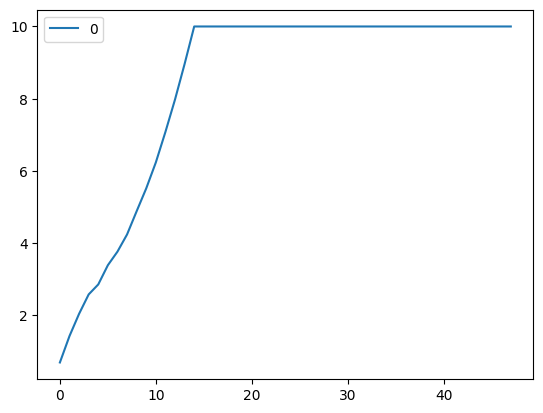

In [9]:
import pandas as pd
pd.DataFrame(tensordict_result['next','soe']).plot()

<Axes: >

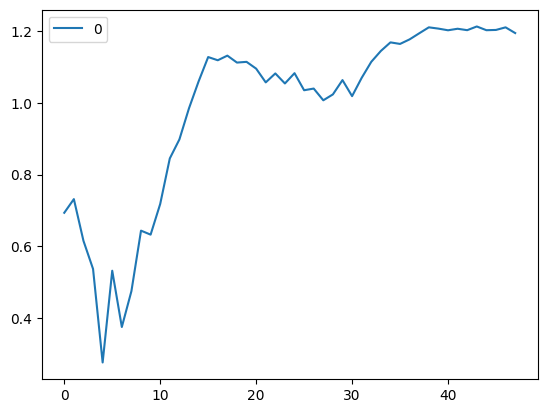

In [10]:
pd.DataFrame(tensordict_result[0:48]['action'].detach().numpy()).plot()

<Axes: >

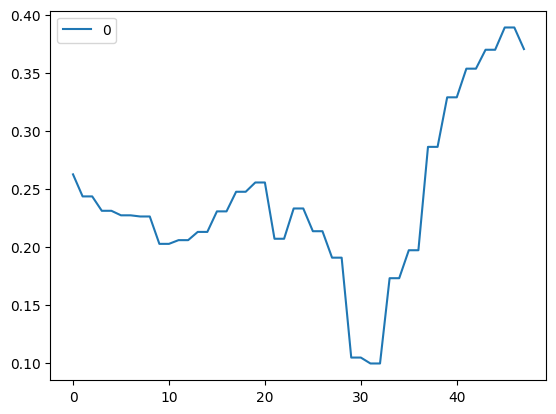

In [11]:
pd.DataFrame(tensordict_result[0:48]['price'].detach().numpy()).plot()

<Axes: >

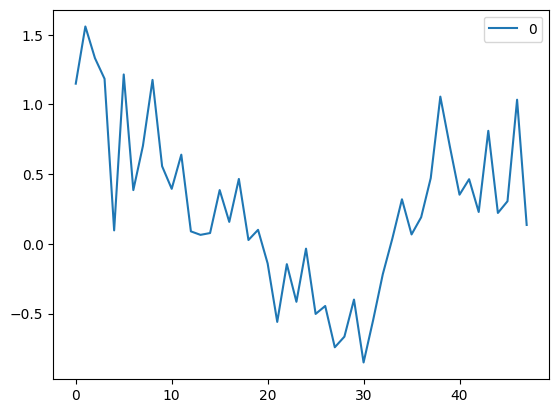

In [12]:
pd.DataFrame(tensordict_result[0:48]['prosumption'].detach().numpy()).plot()

<Axes: >

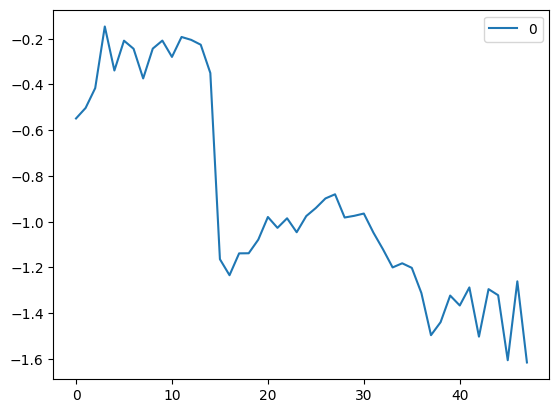

In [13]:
pd.DataFrame(tensordict_result[0:48]['next', 'reward'].detach().numpy()).plot()